### Goal
In this notebook I show a quick and meaningless analysis that could be done from the segmentation we have done so far. In this case I look at the mean intensity of the cytoplasms and nuclei and calculate a ratio. This is then displayed with a nice seaborn plot.

In [1]:
# Import packages
import pandas as pd
import numpy as np
import tifffile as tf
from matplotlib import pyplot as plt
import seaborn as sns
import napari
from napari.utils import nbscreenshot
from skimage.measure import regionprops_table

In [2]:
# Define paths
data_path = '../data/'
output_path = '../results/'

In [3]:
# Load images and tracked labels
cells = tf.imread(data_path + 'xy1_cells.tif')
nuclei = tf.imread(data_path + 'xy1_nuclei.tif')
cell_labels = tf.imread(output_path + 'xy1_tracked_cells.tif')
nuclei_labels = tf.imread(output_path + 'xy1_tracked_nuclei.tif')

### Map cell labels to nuclei labels
It's important to notice that at this point our nuclei and cells have been segmented and classified completely  independently. This means that the nuclear and cellular label values are different and most importantly **independent**.

In order to fix this I decided to assign the cell label value to the corresponding nucleus with the matrix operations below.

divide by zero encountered in true_divide


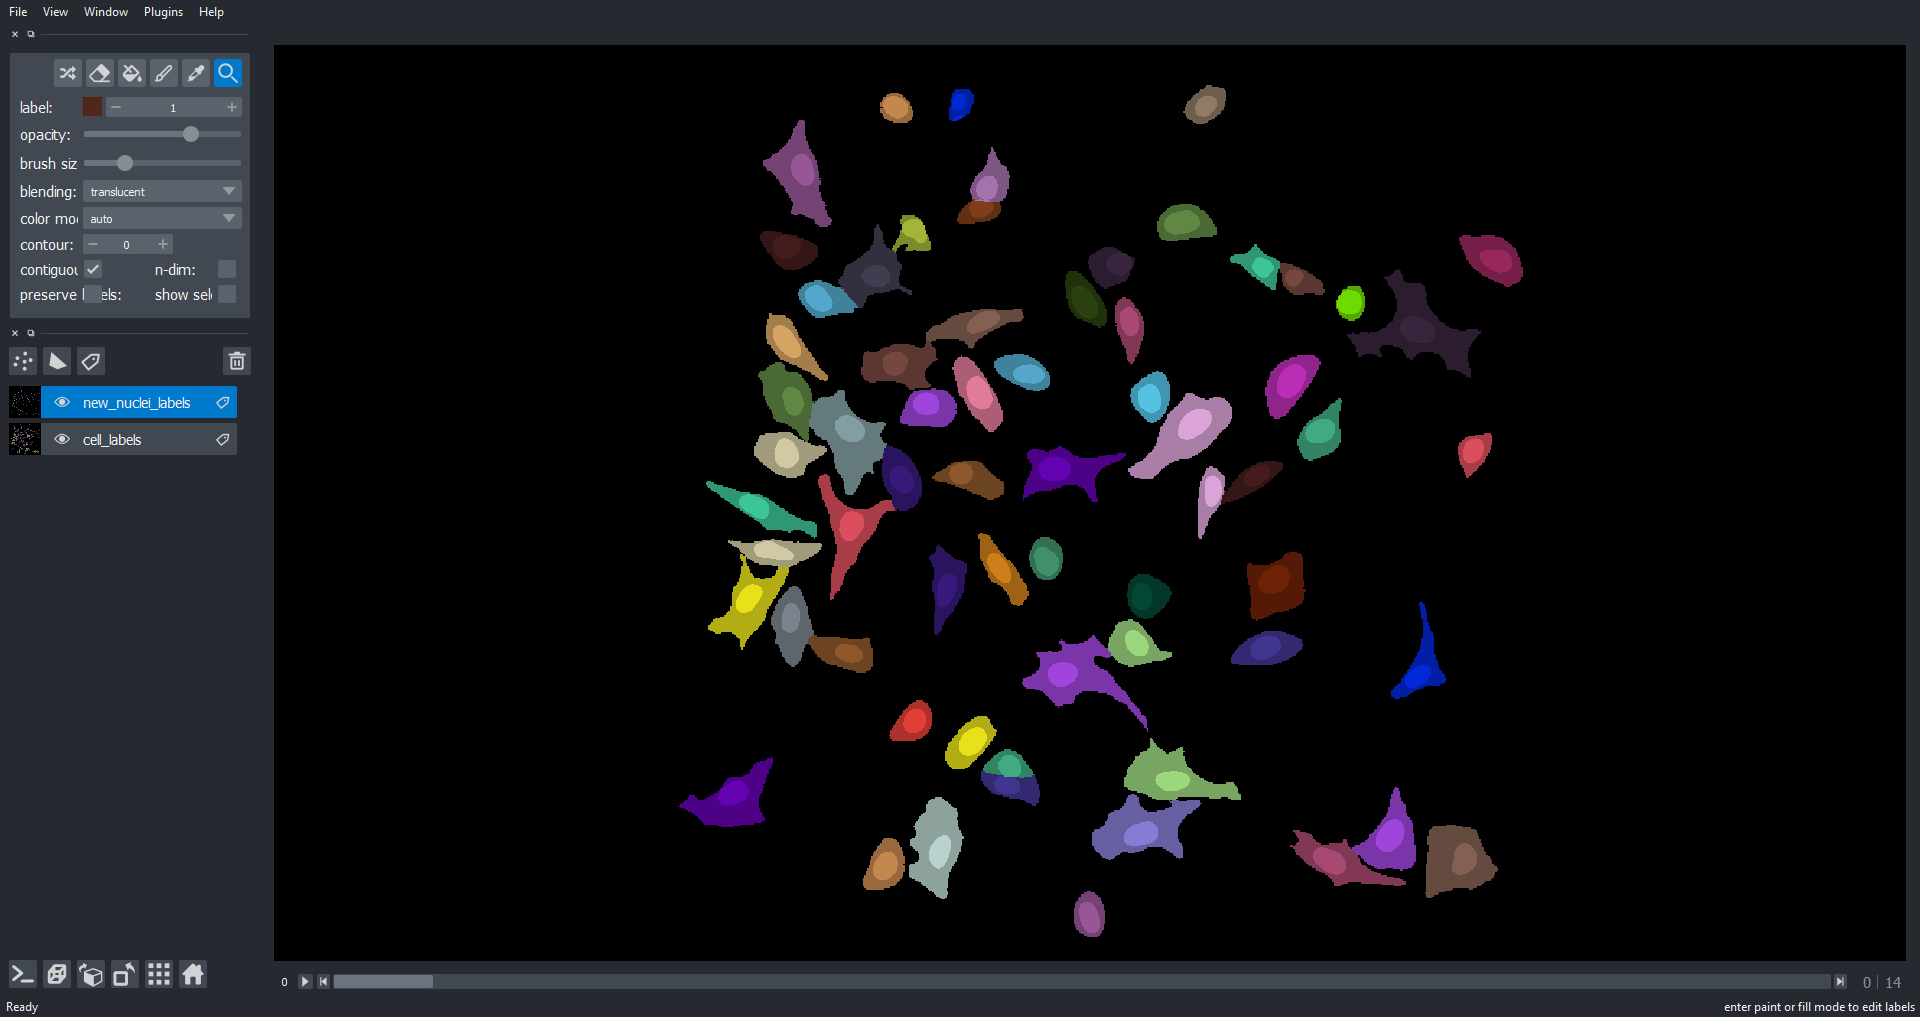

In [5]:
# Create a correspondence between nuclei and cells, i.e. give nuclei same label value as corresponding cells
# plus remove nuclei that don't correspond to any cell
nuclei_binary = nuclei_labels > 1 # binarize nuclei labels
new_nuclei_labels =  nuclei_binary * cell_labels # where there are nuclei give them values of cells
cytoplasm_labels = cell_labels - new_nuclei_labels # create labels for cytoplasms only without nuclei 

# Check in napari everything works
v = napari.Viewer()
v.add_labels(cell_labels)
v.add_labels(new_nuclei_labels)
# v.add_labels(nuclei_labels)
# v.add_labels(cytoplasm_labels)
nbscreenshot(v)

In [6]:
# Export new nuclei labels
tf.imwrite(output_path + 'nuclei_remapped.tif',  new_nuclei_labels)

### Calculate cell properties
To calculate properties of each of our segmented areas I used the famous regionprops. In this case, I find the table format convenient to append all the frames together.

### Disclaimer
Keep in mind that the calculation I am doing here are meaningless, i.e. they don't correspond to the objectives of the experiment performed when obtaining the images. This is purely an example of how to proceed from the segmented images to actual numberical values.

### Obvious improvements
1. I didn't subtract a background value from the mean intensities I obtain from regionprops. Usually I would define a bg area directly in napari when I examine my segmentation and save it to disk. The load it and subtract the mean value of the background area from all other intensities
2. The calculated cytoplasm/nuclear ratio could be useful for a translocation experiment, which this is **not**.

In [7]:
# Calculate properties of segmented cells
df_cells = pd.DataFrame()
df_nuclei = pd.DataFrame()
for frame, (cyto, cell) in enumerate(zip(cytoplasm_labels, cells)): # go frame by frame otherwise regionprops will think this is a 3D image (volume)
    props = regionprops_table(cyto, intensity_image=cell, properties=['label','mean_intensity', 'area'])
    props['frame'] = frame # add frame to keep track of which frame we are measuring in
    temp = pd.DataFrame(props)
    df_cells = pd.concat([df_cells, temp]) # concatenate current frame props with the other ones
    
for frame, (nuc, cell) in enumerate(zip(new_nuclei_labels, cells)):
    props = regionprops_table(nuc, intensity_image=cell, properties=['label','mean_intensity', 'area'])
    props['frame'] = frame
    temp = pd.DataFrame(props)
    df_nuclei = pd.concat([df_nuclei, temp])


In [8]:
# Basic pandas handling for merging nuclear and cytoplasmic props and  export
df_cells.columns = ['label', 'cyto_int', 'cyto_area', 'frame']
df_nuclei.columns = ['label', 'nuc_int', 'nuc_area', 'frame']
df_tot = df_cells.merge(df_nuclei, on=['label', 'frame'])
df_tot['cyto_nuc_ratio'] = df_tot['cyto_int'] / df_tot['nuc_int']
df_tot.to_csv(output_path+'nuclear_cytoplasmatic_props.csv')

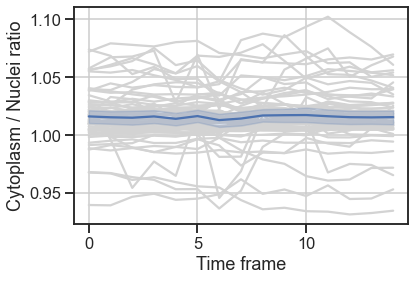

In [9]:
# Basic line plot of calculated props
sns.set(context='talk', style='ticks')
f, ax = plt.subplots(1)
sns.lineplot(data=df_tot, x='frame', y='cyto_nuc_ratio', units='label', estimator=None, color='lightgray', ax=ax)
sns.lineplot(data=df_tot, x='frame', y='cyto_nuc_ratio',  err_kws={'zorder':100.0}, ax=ax)
ax.set_xlabel('Time frame')
ax.set_ylabel('Cytoplasm / Nuclei ratio')
plt.grid()
plt.savefig(output_path+'nuclear_cytoplasmatic_plot.pdf', bbox_inches='tight')
plt.show()

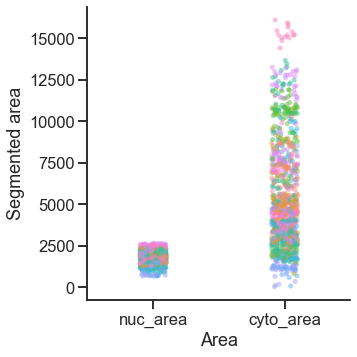

In [10]:
df_melt = df_tot.melt(id_vars=['label'], value_vars=['nuc_area', 'cyto_area'])
g = sns.catplot(data=df_melt, x='variable', y='value', hue='label', alpha=0.5, legend=False)
g.set(xlabel='Area', ylabel='Segmented area')
plt.savefig(output_path+'area_by_region.pdf', bbox_inches='tight')
plt.show()